<center>
    
# 2D Population Dynamics

### Juan Sebastian Sierra Jaraba - jsierraj@unal.edu.co 
### Departamento de Física, Facultad de Ciencias, Sede Bogotá
### Universidad Nacional de Colombia
    
</center>

Ecuación de densidades poblacionales de vegetación $V$, presa $P$ y depredador $D$ sobre un mapa:

$$
\begin{align}
\frac{\partial V}{\partial t} &= V(\alpha - \beta P - \gamma V) \\
\frac{\partial P}{\partial t} + \vec{\nabla} \cdot \vec{J}_P &= P(\delta V - \varepsilon D) \\
\frac{\partial D}{\partial t} + \vec{\nabla} \cdot \vec{J}_D &= D(\zeta P - \eta)
\end{align}
$$

Densidades de corriente de depredadores y presas:

$$ 
\begin{align}
\vec{J}_P &= P\vec{v_P} = P(\theta\vec{\nabla}V - \iota\vec{\nabla}D) \\
\vec{J}_D &= D\vec{v_D} = D\kappa\vec{\nabla}P 
\end{align}
$$

Donde $\alpha$, $\beta$, $\gamma$, $\delta$, $\varepsilon$, $\zeta$, $\eta$, $\theta$, $\iota$ y $\kappa$ son constantes.

Ecuaciones completas:

$$
\begin{align}
\frac{\partial V}{\partial t} &= V(\alpha - \beta P - \gamma V) \\
\frac{\partial P}{\partial t} &= P(\delta V - \varepsilon D) - \theta(P\vec{\nabla}²V + \vec{\nabla}P\cdot\vec{\nabla}V) + \iota(P\vec{\nabla}²D + \vec{\nabla}P\cdot\vec{\nabla}D)\\
\frac{\partial D}{\partial t} &= D(\zeta P - \eta) - \kappa(D\vec{\nabla}²P + \vec{\nabla}D\cdot\vec{\nabla}P)
\end{align}
$$


In [25]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [26]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
params = {
    'alpha': 1.0,  # Tasa de crecimiento de la vegetación
    'beta': 0.01,  # Tasa de consumo de vegetación por las presas
    'gamma': 0.1,  # Tasa de saturación de vegetación
    'delta': 0.02, # Tasa de reproducción de presas por vegetación
    'epsilon': 0.03, # Tasa de depredación de presas
    'zeta': 0.015,  # Tasa de reproducción de depredadores por presas
    'eta': 0.01,    # Tasa de muerte de depredadores
    'theta': 0.02,  # Coeficiente de interacción espacial presa-vegetación
    'iota': 0.05,   # Coeficiente de interacción espacial presa-depredador
    'kappa': 0.05,  # Coeficiente de interacción espacial depredador-presa
    'Dv': 0.00,    # Coeficiente de difusión para vegetación
    'Dp': 0.001,    # Coeficiente de difusión para presas
    'Dd': 0.001     # Coeficiente de difusión para depredadores
}

# Define the spatial grid
nx, ny = 150, 150  # Grid size
Lx, Ly = 10.0, 10.0  # Physical dimensions of the domain
dx, dy = Lx / nx, Ly / ny  # Grid spacing

x, y = np.linspace(0, Lx, nx), np.linspace(0, Ly, ny)
x, y = np.meshgrid(x, y)

V0 = params['alpha'] / params['gamma'] * (np.ones((nx, ny)))
P0 = 10 * np.exp(-((x - 5)**2 + (y - 5)**2) / 2.0)  # Localized prey population
D0 = 5 * np.exp(-((x - 7)**2 + (y - 7)**2) / 2.0)   # Localized predator population


In [27]:
# Laplacian function
def laplacian(Z, dx, dy):
    Zx = (np.roll(Z, -1, axis=0) - 2 * Z + np.roll(Z, 1, axis=0)) / dx**2
    Zy = (np.roll(Z, -1, axis=1) - 2 * Z + np.roll(Z, 1, axis=1)) / dy**2
    return Zx + Zy

In [28]:
# System of equations
def system(t, y, params, nx, ny, dx, dy):
    V = y[:nx*ny].reshape((nx, ny))
    P = y[nx*ny:2*nx*ny].reshape((nx, ny))
    D = y[2*nx*ny:].reshape((nx, ny))

    # Retrieve parameters
    alpha, beta, gamma = params['alpha'], params['beta'], params['gamma']
    delta, epsilon, zeta, eta = params['delta'], params['epsilon'], params['zeta'], params['eta']
    theta, iota, kappa = params['theta'], params['iota'], params['kappa']
    Dv, Dp, Dd = params['Dv'], params['Dp'], params['Dd']

    # Equations
    gradP = np.gradient(P)
    gradV = np.gradient(V)
    gradD = np.gradient(D)

    dVdt = V * (alpha - beta * P - gamma * V) + Dv * laplacian(V, dx, dy)
    dPdt = (P * (delta * V - epsilon * D) - theta * (P * laplacian(V, dx, dy) + gradP[0] * gradV[0] + gradP[1] * gradV[1]) + iota * (P * laplacian(D, dx, dy) + gradP[0] * gradD[0] + gradP[1] * gradD[1]) + Dp * laplacian(P, dx, dy))
    dDdt = (D * (zeta * P - eta) - kappa * (D * laplacian(P, dx, dy) + gradD[0] * gradP[0] + gradD[1] * gradP[1]) + Dd * laplacian(D, dx, dy))

    # Debugging: Print max values
    print(f"t = {t:.2f}, max(dVdt) = {np.max(dVdt):.4f}, max(dPdt) = {np.max(dPdt):.4f}, max(dDdt) = {np.max(dDdt):.4f}")

    return np.concatenate([dVdt.ravel(), dPdt.ravel(), dDdt.ravel()])

In [29]:
# Flatten initial conditions
y0 = np.concatenate([V0.ravel(), P0.ravel(), D0.ravel()])

T_max = 20

# Time integration
time_span = (0, T_max)  # Time range for simulation
time_eval = np.linspace(0, T_max, 100 * T_max)  # Time points to evaluate

solution = solve_ivp(
    system,
    time_span,
    y0,
    args=(params, nx, ny, dx, dy),
    t_eval=time_eval,
    method='RK45',  # Use a stiff solver
    atol=1e-8,     # Absolute tolerance
    rtol=1e-8      # Relative tolerance
)

t = 0.00, max(dVdt) = -0.0000, max(dPdt) = 2.2785, max(dDdt) = 0.3870
t = 0.14, max(dVdt) = -0.0000, max(dPdt) = 2.2563, max(dDdt) = 0.4405
t = 0.00, max(dVdt) = -0.0000, max(dPdt) = 2.2777, max(dDdt) = 0.3884
t = 0.01, max(dVdt) = -0.0000, max(dPdt) = 2.2773, max(dDdt) = 0.3891
t = 0.02, max(dVdt) = -0.0000, max(dPdt) = 2.2753, max(dDdt) = 0.3925
t = 0.02, max(dVdt) = -0.0000, max(dPdt) = 2.2750, max(dDdt) = 0.3931
t = 0.02, max(dVdt) = -0.0000, max(dPdt) = 2.2745, max(dDdt) = 0.3938
t = 0.02, max(dVdt) = -0.0000, max(dPdt) = 2.2745, max(dDdt) = 0.3938
t = 0.05, max(dVdt) = -0.0000, max(dPdt) = 2.2687, max(dDdt) = 0.4045
t = 0.06, max(dVdt) = -0.0000, max(dPdt) = 2.2670, max(dDdt) = 0.4097
t = 0.13, max(dVdt) = -0.0000, max(dPdt) = 2.2568, max(dDdt) = 0.4356
t = 0.14, max(dVdt) = -0.0000, max(dPdt) = 2.2540, max(dDdt) = 0.4396
t = 0.16, max(dVdt) = -0.0000, max(dPdt) = 2.2515, max(dDdt) = 0.4453
t = 0.16, max(dVdt) = -0.0000, max(dPdt) = 2.2526, max(dDdt) = 0.4460
t = 0.19, max(dVdt) 

KeyboardInterrupt: 

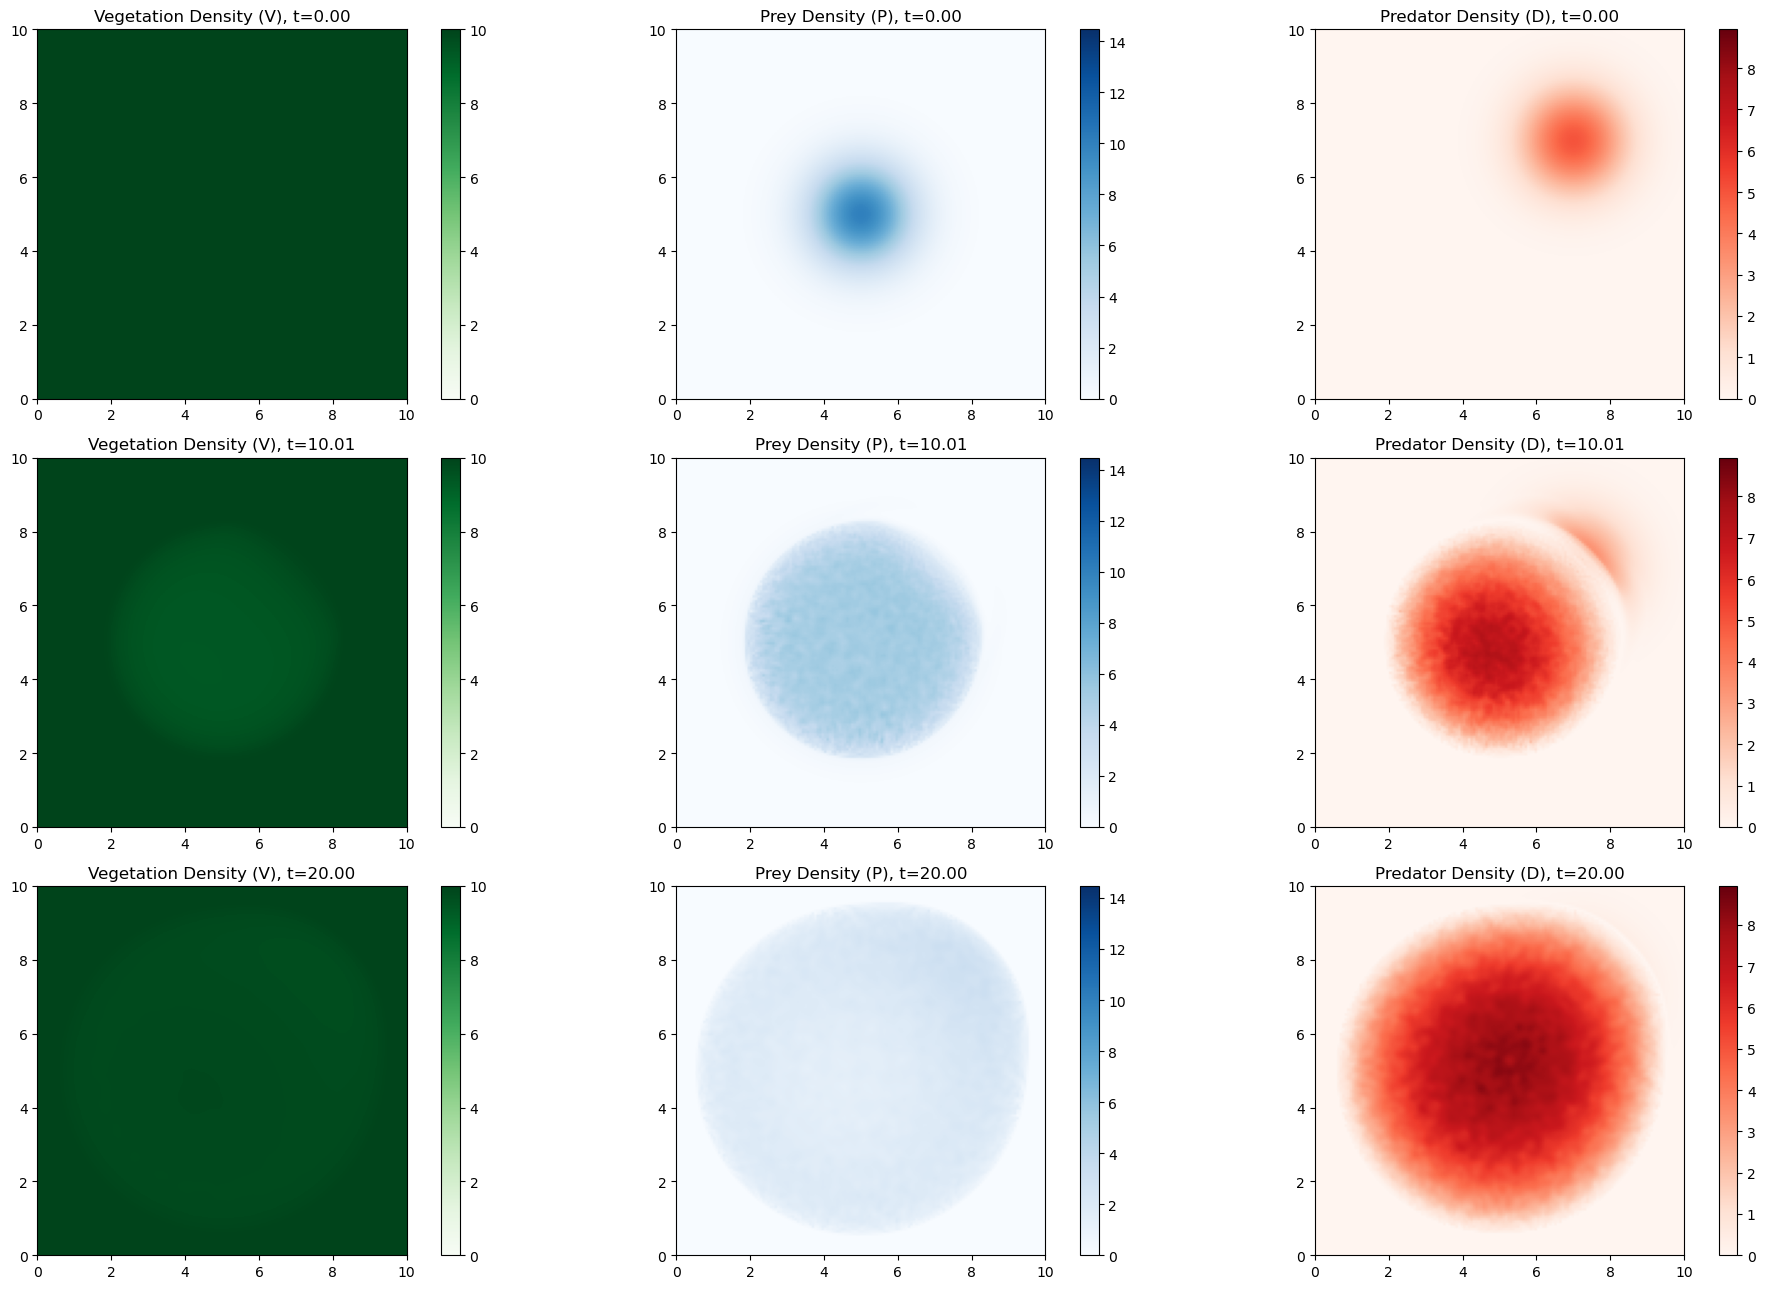

In [12]:
# Reshape results
V = solution.y[:nx*ny, :].reshape((nx, ny, -1))
P = solution.y[nx*ny:2*nx*ny, :].reshape((nx, ny, -1))
D = solution.y[2*nx*ny:, :].reshape((nx, ny, -1))

# Plot results
vmin_V, vmax_V = 0.0, V.max()  # Vegetation density range
vmin_P, vmax_P = 0.0, P.max()  # Prey density range
vmin_D, vmax_D = 0.0, D.max()  # Predator density range

# Plot results for different time steps
N_steps = 2
steps = np.concatenate((np.array(np.linspace(0, N_steps-1, N_steps)*len(time_eval)//N_steps, dtype=int), [-1]))
plt.figure(figsize=(20, 5*N_steps+3))

for i, step in enumerate(steps):
    plt.subplot(len(steps), 3, i * 3 + 1)
    plt.title(f'Vegetation Density (V), t={solution.t[step]:.2f}')
    plt.imshow(V[:, :, step], extent=[0, Lx, 0, Ly], origin='lower', cmap='Greens', vmin=vmin_V, vmax=vmax_V)
    plt.colorbar()

    plt.subplot(len(steps), 3, i * 3 + 2)
    plt.title(f'Prey Density (P), t={time_eval[step]:.2f}')
    plt.imshow(P[:, :, step], extent=[0, Lx, 0, Ly], origin='lower', cmap='Blues', vmin=vmin_P, vmax=vmax_P)
    plt.colorbar()

    plt.subplot(len(steps), 3, i * 3 + 3)
    plt.title(f'Predator Density (D), t={time_eval[step]:.2f}')
    plt.imshow(D[:, :, step], extent=[0, Lx, 0, Ly], origin='lower', cmap='Reds', vmin=vmin_D, vmax=vmax_D)
    plt.colorbar()

plt.tight_layout()
plt.show()

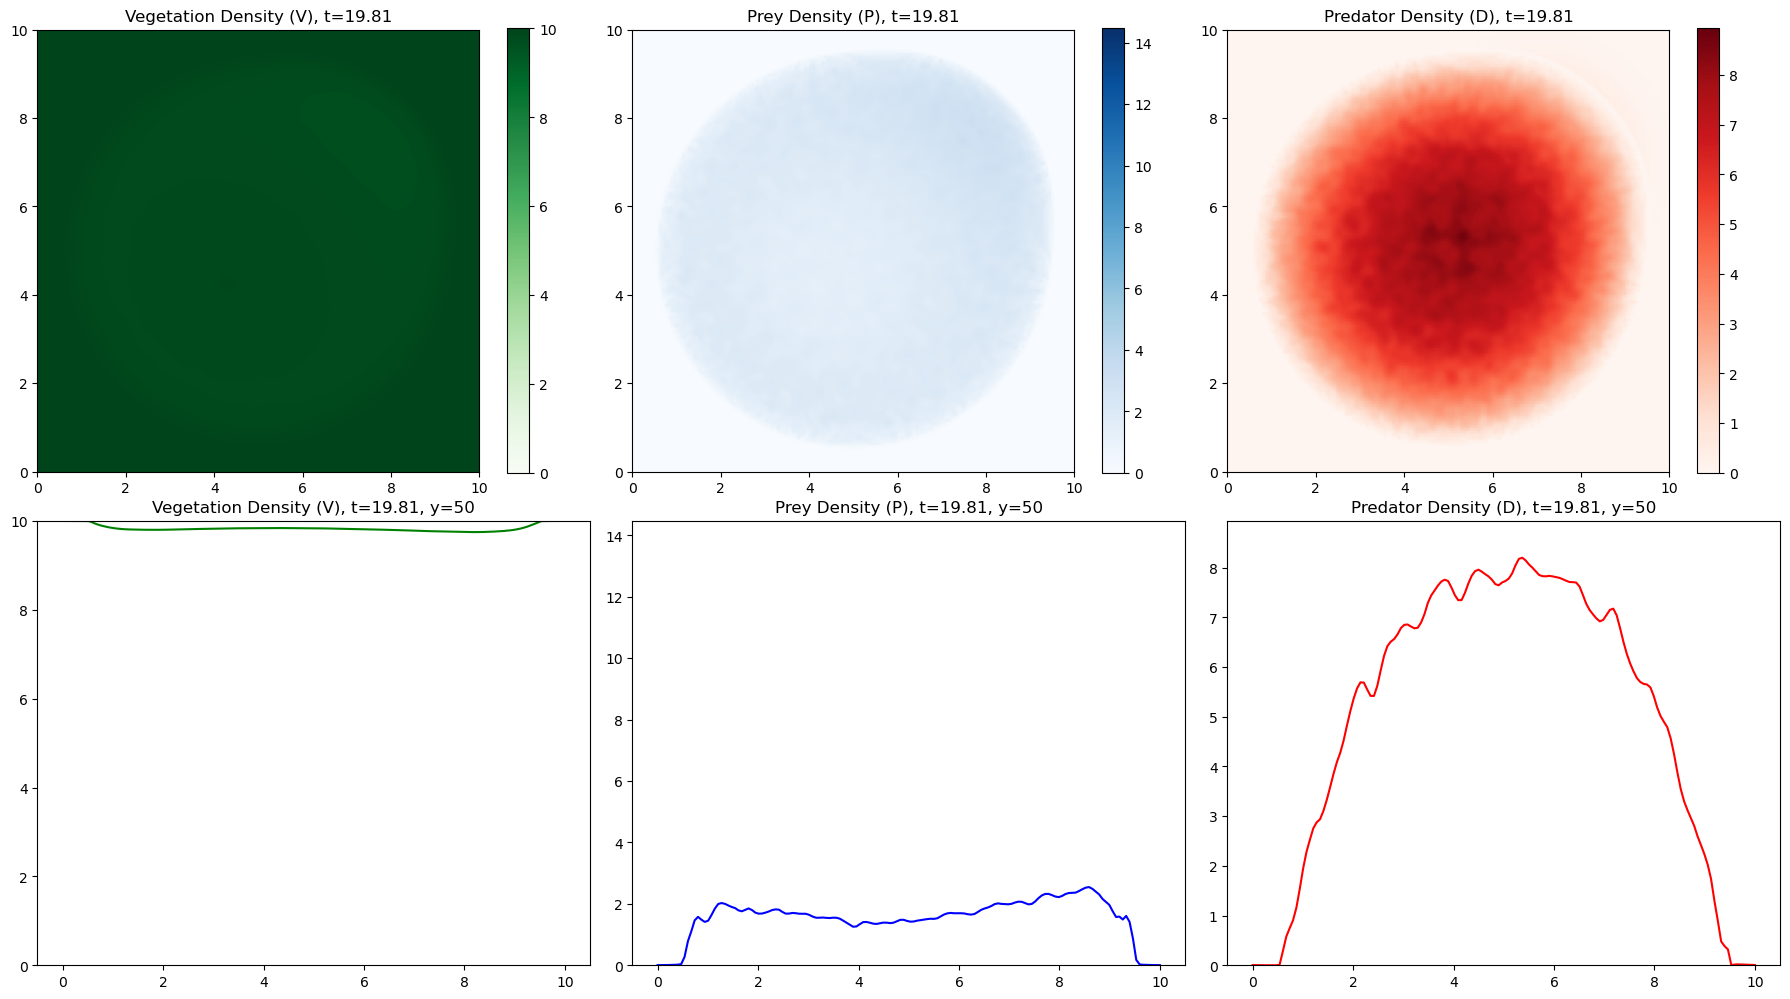

GIF saved as 'population_density_animation.gif'


In [31]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

# Define time steps
N_steps = 100
steps = np.concatenate((np.array(np.linspace(0, N_steps-1, N_steps) * len(time_eval) // N_steps, dtype=int), [-1]))

# Create a figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Create a grid of 2x3 subplots

# Plot initial images (do this only once)
im1 = axes[0, 0].imshow(V[:, :, steps[0]], extent=[0, Lx, 0, Ly], origin='lower', cmap='Greens', vmin=vmin_V, vmax=vmax_V)
axes[0, 0].set_title(f'Vegetation Density (V), t={solution.t[steps[0]]:.2f}')
cbar1 = fig.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(P[:, :, steps[0]], extent=[0, Lx, 0, Ly], origin='lower', cmap='Blues', vmin=vmin_P, vmax=vmax_P)
axes[0, 1].set_title(f'Prey Density (P), t={time_eval[steps[0]]:.2f}')
cbar2 = fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[0, 2].imshow(D[:, :, steps[0]], extent=[0, Lx, 0, Ly], origin='lower', cmap='Reds', vmin=vmin_D, vmax=vmax_D)
axes[0, 2].set_title(f'Predator Density (D), t={time_eval[steps[0]]:.2f}')
cbar3 = fig.colorbar(im3, ax=axes[0, 2])

# Plot initial line plots (do this only once)
Dom_x = np.linspace(0, Lx, nx)
im4, = axes[1, 0].plot(Dom_x, V[:, ny//2, steps[0]], color='green')
axes[1, 0].set_title(f'Vegetation Density (V), t={solution.t[steps[0]]:.2f}, y=50')
axes[1, 0].set_ylim([0, V.max()])

im5, = axes[1, 1].plot(Dom_x, P[:, ny//2, steps[0]], color='blue')
axes[1, 1].set_title(f'Prey Density (P), t={solution.t[steps[0]]:.2f}, y=50')
axes[1, 1].set_ylim([0, P.max()])

im6, = axes[1, 2].plot(Dom_x, D[:, ny//2, steps[0]], color='red')
axes[1, 2].set_title(f'Predator Density (D), t={solution.t[steps[0]]:.2f}, y=50')
axes[1, 2].set_ylim([0, D.max()])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Update function for animation
def update(i):
    # Update the Vegetation plot
    im1.set_array(V[:, :, steps[i]])
    axes[0, 0].set_title(f'Vegetation Density (V), t={solution.t[steps[i]]:.2f}')

    # Update the Prey plot
    im2.set_array(P[:, :, steps[i]])
    axes[0, 1].set_title(f'Prey Density (P), t={time_eval[steps[i]]:.2f}')

    # Update the Predator plot
    im3.set_array(D[:, :, steps[i]])
    axes[0, 2].set_title(f'Predator Density (D), t={time_eval[steps[i]]:.2f}')

    # Update the line plots
    im4.set_data(Dom_x, V[:, ny//2, steps[i]])
    axes[1, 0].set_title(f'Vegetation Density (V), t={solution.t[steps[i]]:.2f}, y=50')

    im5.set_data(Dom_x, P[:, ny//2, steps[i]])
    axes[1, 1].set_title(f'Prey Density (P), t={solution.t[steps[i]]:.2f}, y=50')

    im6.set_data(Dom_x, D[:, ny//2, steps[i]])
    axes[1, 2].set_title(f'Predator Density (D), t={solution.t[steps[i]]:.2f}, y=50')

    return im1, im2, im3, im4, im5, im6  # Return the updated objects

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=N_steps, interval=50, blit=True)

# Save the animation as a GIF
writer = PillowWriter(fps=20)  # Frames per second (adjust as needed)
ani.save("population_density_animation.gif", writer=writer)

# Optionally show the plot
plt.show()

print("GIF saved as 'population_density_animation.gif'")